# **MA5608 Optimización estocástica y aprendizaje de máquinas**

## **Sesión práctica 1: ¿Cómo optimizar redes neuronales? Desde el SGD a Adam.**

En esta sesión veremos lo que hacen los *backends* de *deep learning* por detrás con respecto al armado de la red y de su optimización, además de ver cómo programar los algoritmos de optimización más usados, incluyendo el autogradiente, una técnica clave en cuanto a redes neuronales.

En esta sesión solo usaremos NumPy (y un par de cosas más), pero ningún *backend* de *deep learning*, esto se dejará para la siguiente sesión con algunas aplicaciones de arquitecturas interesantes.

In [ ]:
# Librerías usuales
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time

## **Descenso de gradiente estocástico v/s Otros algoritmos**

Implementación con NumPy.

In [ ]:
class NeuralNetworkNumPy:
    # Constructor de la red neuronal
    def __init__(self, input_size, hidden_size, output_size, activation):
        # Inicializa los tamaños de las capas
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Inicializa los pesos con valores aleatorios (distribución normal estándar)
        self.weights_input_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.weights_hidden_output = np.random.randn(self.hidden_size, self.output_size)

        # Inicializa los sesgos con ceros
        self.bias_hidden = np.zeros(self.hidden_size)
        self.bias_output = np.zeros(self.output_size)

        # Guarda la función de activación
        self.activation = activation

        # Calcula el número total de parámetros (pesos + sesgos)
        self.n_params = self.input_size*self.hidden_size + self.hidden_size*self.output_size + self.hidden_size + self.output_size

    # Método para el paso hacia adelante (forward pass)
    def forward(self, X):
        # Calcula la entrada a la capa oculta (X * W_ih + b_h)
        self.hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden

        # Aplica la función de activación a la capa oculta
        self.hidden_output = self.activation(self.hidden_input)

        # Calcula la salida de la red (hidden_output * W_ho + b_o)
        output = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        return output

In [ ]:
# Define los tamaños de las capas de la red neuronal
input_size, hidden_size, output_size = 1, 100, 1
# Define la función de activación a usar (tangente hiperbólica en este caso)
activation = np.tanh
# Crea una instancia de la red neuronal con los tamaños y función de activación definidos
model = NeuralNetworkNumPy(input_size=input_size,
                           hidden_size=hidden_size,
                           output_size=output_size,
                           activation=activation)

# Define la cantidad de datos de entrada
n_data = 10
# Genera datos de entrada aleatorios con el tamaño definido
X = np.random.rand(n_data, input_size)
# Realiza un paso hacia adelante (forward pass) con los datos de entrada
output = model.forward(X)
# Imprime la salida de la red neuronal
print(output)

[[-6.54717912]
 [-4.39494038]
 [-6.7420957 ]
 [-5.81290604]
 [-0.22658397]
 [-6.8308929 ]
 [-5.94940611]
 [-6.80913561]
 [-3.07091467]
 [-4.97214425]]


Text(0.5, 1.0, 'Datos de entrada vs. seno(Datos de entrada)')

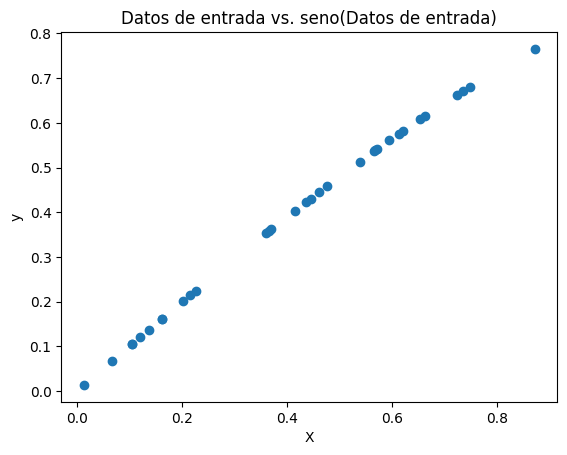

In [ ]:
# Define el número de datos a generar
n_data = 32
# Genera datos de entrada aleatorios con el tamaño definido
X = np.random.rand(n_data, input_size)
# Calcula los valores de salida correspondientes utilizando la función seno
y = np.sin(X)

# Crea un gráfico de dispersión de los datos generados
plt.scatter(X, y)
# Añade una etiqueta al eje x
plt.xlabel("X")
# Añade una etiqueta al eje y
plt.ylabel("y")
# Añade un título al gráfico
plt.title("Datos de entrada vs. seno(Datos de entrada)")

In [ ]:
def loss(theta, X, y):
    # Extrae los pesos y sesgos del vector de parámetros theta
    weights = theta[:model.input_size*model.hidden_size + model.hidden_size*model.output_size]
    biases = theta[model.input_size*model.hidden_size + model.hidden_size*model.output_size:]

    # Reorganiza los pesos en las matrices correspondientes a las capas de la red neuronal
    model.weights_input_hidden = weights[:hidden_size*input_size].reshape(input_size, hidden_size)
    model.weights_hidden_output = weights[hidden_size*input_size:].reshape(hidden_size, output_size)

    # Asigna los sesgos a los vectores correspondientes a las capas de la red neuronal
    model.bias_hidden = biases[:hidden_size]
    model.bias_output = biases[hidden_size:]

    # Realiza un paso hacia adelante (forward pass) con los datos de entrada X
    y_pred = model.forward(X)

    # Calcula la pérdida utilizando el Error Cuadrático Medio (MSE)
    return np.mean((y - y_pred)**2)

In [ ]:
def gradient(f, theta, args, h=1e-6):
    # Calcula una aproximación del gradiente de la función f utilizando diferencias finitas centradas.
    # f: La función de la cual se calculará el gradiente.
    # theta: El punto en el cual se calculará el gradiente.
    # args: Argumentos adicionales para la función f.
    # h: El tamaño del paso para las diferencias finitas (por defecto 1e-6).
    grad = f(theta+h, *args) - f(theta-h, *args)
    return grad/(2*h)

In [ ]:
# Optimización con descenso de gradiente estocástico

# Inicializa los parámetros de la red neuronal con valores aleatorios
theta = np.random.rand(model.n_params)
# Define el número de épocas (iteraciones completas sobre todos los datos)
n_epochs, n_batches = 500, 16

# Función para crear lotes (batches) de datos
def create_batches(X, y, n_batches):
    batches = []
    # Itera sobre el número de lotes
    for i in range(n_batches):
        # Calcula los índices de inicio y fin para cada lote
        start_index = i * len(X) // n_batches
        end_index = (i + 1) * len(X) // n_batches
        # Añade un lote de datos a la lista de lotes
        batches.append((X[start_index:end_index], y[start_index:end_index]))
    return batches

# Crea los lotes de datos de entrenamiento
batches = create_batches(X, y, n_batches)
# Inicializa una lista para almacenar el historial de pérdidas
loss_history = []

# Registra el tiempo de inicio para la optimización con SGD
sgd_time = time()
# Itera sobre cada época
for epoch in range(n_epochs):
    # Itera sobre cada lote en la época actual
    for i in range(len(batches)):
        # Obtiene el lote actual de datos de entrada y salida
        X_batch, y_batch = batches[i]
        # Realiza un paso hacia adelante con el lote actual para obtener las predicciones
        y_pred = model.forward(X_batch)
        # Calcula el valor de la función de pérdida (Error Cuadrático Medio) para el lote actual
        loss_val = np.mean((y_batch - y_pred)**2)
        # Calcula el gradiente de la función de pérdida con respecto a los parámetros
        grad = gradient(loss, theta, (X_batch, y_batch))/len(X_batch)
        # Actualiza los parámetros utilizando el descenso de gradiente estocástico
        theta -= 1e-4*grad
        # Almacena el valor de la pérdida en el historial
        loss_history.append(loss_val)

# Calcula el tiempo total de ejecución para la optimización con SGD
sgd_time = time() - sgd_time
# Imprime el tiempo de ejecución
print(f"Tiempo de ejecución: {sgd_time}")

Tiempo de ejecución: 0.8218886852264404


Text(0.5, 1.0, 'Historial de pérdida con Descenso de Gradiente Estocástico')

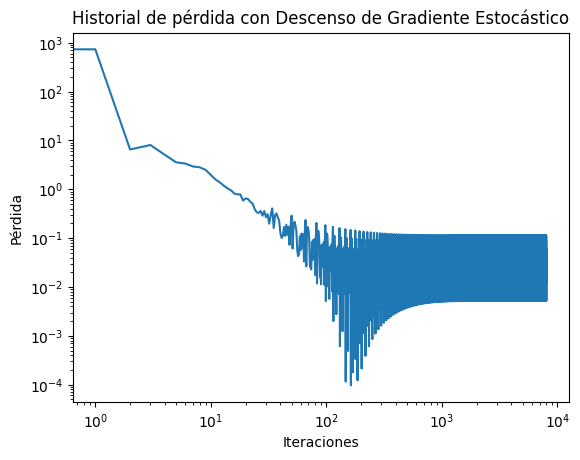

In [ ]:
# Grafica el historial de pérdida
plt.plot(loss_history)
# Establece la escala del eje y a logarítmica
plt.yscale("log")
# Establece la escala del eje x a logarítmica
plt.xscale("log")
# Añade una etiqueta al eje x
plt.xlabel("Iteraciones")
# Añade una etiqueta al eje y
plt.ylabel("Pérdida")
# Añade un título al gráfico
plt.title("Historial de pérdida con Descenso de Gradiente Estocástico")

In [ ]:
# Optimización con algoritmo evolutivo
import scipy.optimize as opt
from scipy.optimize import differential_evolution

# Registra el tiempo de inicio para la optimización con Differential Evolution
diff_ev_time = time()
# Realiza la optimización utilizando el algoritmo Differential Evolution
# loss: La función de pérdida a minimizar.
# bounds: Los límites para cada parámetro. En este caso, se utilizan límites de -1e4 a 1e4 para todos los parámetros.
# args: Argumentos adicionales para la función de pérdida (X, y).
# maxiter: El número máximo de iteraciones. Se establece en 5 para evitar un tiempo de ejecución excesivo.
sol = differential_evolution(loss, bounds=[(-1e4, 1e4)]*model.n_params, args=(X, y), maxiter=5)
# Calcula el tiempo total de ejecución para la optimización con Differential Evolution
diff_ev_time = time() - diff_ev_time

# Imprime el tiempo de ejecución
print(f"Tiempo de ejecución: {diff_ev_time}")
# Imprime el resultado de la optimización
print(sol)

Tiempo de ejecución: 13.60834288597107
             message: Maximum number of iterations has been exceeded.
             success: False
                 fun: 0.00048082070230833824
                   x: [ 1.268e+03  6.854e+02 ... -6.256e+03 -6.764e+03]
                 nit: 5
                nfev: 39472
          population: [[ 1.268e+03  6.854e+02 ... -6.256e+03 -6.717e+03]
                       [ 8.014e+03 -1.934e+03 ...  9.853e+03  1.458e+03]
                       ...
                       [ 4.744e+03  5.264e+03 ... -8.213e+03  1.086e+03]
                       [-1.959e+03 -4.384e+03 ...  7.764e+03 -5.832e+03]]
 population_energies: [ 4.808e-04  3.852e+08 ...  1.039e+09  2.324e+08]
                 jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  5.507e-05]


Tiempo de ejecución con descenso de gradiente estocástico: 0.8218886852264404
Tiempo de ejecución con algoritmo evolutivo: 13.60834288597107


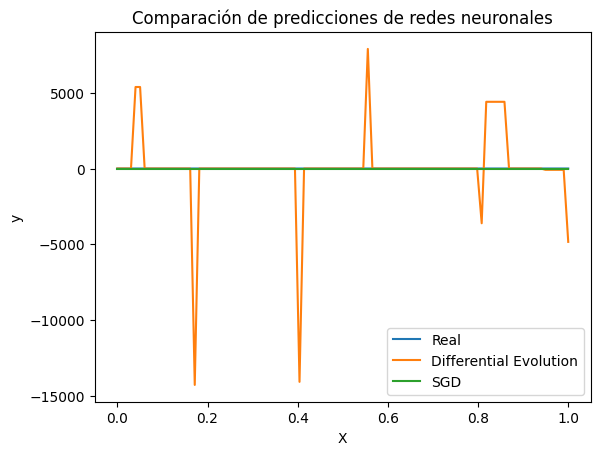

In [ ]:
# Comparación de ambas redes
print(f"Tiempo de ejecución con descenso de gradiente estocástico: {sgd_time}")
print(f"Tiempo de ejecución con algoritmo evolutivo: {diff_ev_time}")

# Crea nuevas instancias de la red neuronal para SGD y Differential Evolution
model_sgd = NeuralNetworkNumPy(input_size=input_size,
                               hidden_size=hidden_size,
                               output_size=output_size,
                               activation=activation)

model_diff_ev = NeuralNetworkNumPy(input_size=input_size,
                                   hidden_size=hidden_size,
                                   output_size=output_size,
                                   activation=activation)

# Asigna los parámetros optimizados por SGD y Differential Evolution a los modelos correspondientes
theta_sgd = theta
theta_diff_ev = sol.x

# Extrae los pesos y sesgos de los parámetros optimizados por SGD
weights_sgd = theta_sgd[:model_sgd.input_size*model_sgd.hidden_size + model_sgd.hidden_size*model_sgd.output_size]
biases_sgd = theta_sgd[model_sgd.input_size*model_sgd.hidden_size + model_sgd.hidden_size*model_sgd.output_size:]

# Reorganiza los pesos y sesgos optimizados por SGD en las matrices y vectores del modelo
model_sgd.weights_input_hidden = weights_sgd[:hidden_size*input_size].reshape(input_size, hidden_size)
model_sgd.weights_hidden_output = weights_sgd[hidden_size*input_size:].reshape(hidden_size, output_size)

model_sgd.bias_hidden = biases_sgd[:hidden_size]
model_sgd.bias_output = biases_sgd[hidden_size:]

# Extrae los pesos y sesgos de los parámetros optimizados por Differential Evolution
weights_diff_ev = theta_diff_ev[:model_diff_ev.input_size*model_diff_ev.hidden_size + model_diff_ev.hidden_size*model_diff_ev.output_size]
biases_diff_ev = theta_diff_ev[model_diff_ev.input_size*model_diff_ev.hidden_size + model_diff_ev.hidden_size*model_diff_ev.output_size:]

# Reorganiza los pesos y sesgos optimizados por Differential Evolution en las matrices y vectores del modelo
model_diff_ev.weights_input_hidden = weights_diff_ev[:hidden_size*input_size].reshape(input_size, hidden_size)
model_diff_ev.weights_hidden_output = weights_diff_ev[hidden_size*input_size:].reshape(hidden_size, output_size)

# Bias
model_diff_ev.bias_hidden = biases_diff_ev[:hidden_size]
model_diff_ev.bias_output = biases_diff_ev[hidden_size:]

# Datos para testear
x_test = np.linspace(0, 1, 100).reshape((1,-1)).T
y_test = np.sin(x_test)

# Realiza un paso hacia adelante con los datos de entrada para obtener las predicciones de ambos modelos
y_pred_sgd = model_sgd.forward(x_test)
y_pred_diff_ev = model_diff_ev.forward(x_test)

# Crea un gráfico de dispersión para comparar los datos reales y las predicciones de ambos modelos
plt.plot(x_test, y_test, label="Real")
plt.plot(x_test, y_pred_diff_ev, label="Differential Evolution")
plt.plot(x_test, y_pred_sgd, label="SGD")
# Añade una etiqueta al eje x
plt.xlabel("X")
# Añade una etiqueta al eje y
plt.ylabel("y")
# Añade un título al gráfico
plt.title("Comparación de predicciones de redes neuronales")
# Muestra la leyenda del gráfico
plt.legend()

## **Descenso de gradiente estocástico**

Veremos cómo implementar el Descenso de Gradiente Estocástico con la librería de autograd, que permite utilizar el autogradiente y con ello no comenter error numérico (salvo de truncación) en el cálculo del gradiente de la pérdida de la red.

In [ ]:
# Numpy de autograd
import autograd.numpy as np

# Función de gradiente mediante diferenciación automática
from autograd import grad

In [ ]:
# Función a aproximar
def f_true(x):
    return 3*np.cos(10*x) - np.sin(x)

In [ ]:
xdim = 1   # Dimensión de input
Ndata = 100 # Cantidad de datos a samplear
ydim = 1   # Dimensión de output

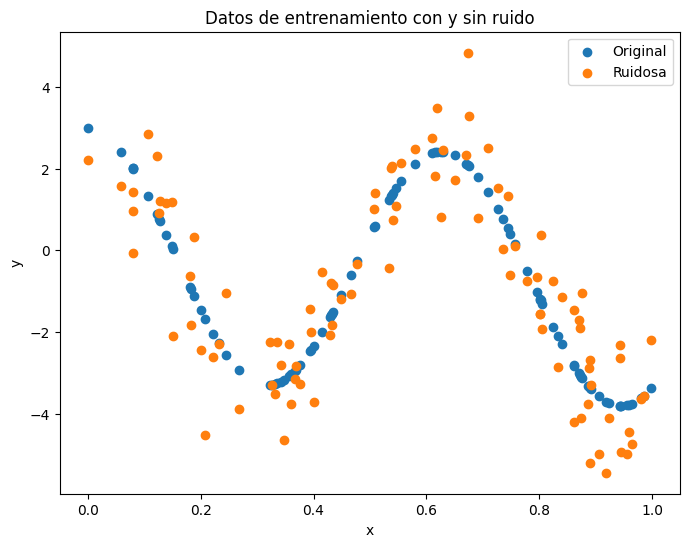

In [ ]:
# Genera datos de entrenamiento aleatorios
x_train = np.random.random((xdim, Ndata))

# Sampleo de datos con ruido
desv = 1
y_train = f_true(x_train) + desv*np.random.randn(*x_train.shape)

# Crea un gráfico de dispersión para visualizar los datos originales y con ruido
plt.figure(figsize=(8,6))
plt.scatter(x_train.flatten(), f_true(x_train).flatten(), label="Original")
plt.scatter(x_train.flatten(), y_train.flatten(), label="Ruidosa")
# Añade una etiqueta al eje x
plt.xlabel("x")
# Añade una etiqueta al eje y
plt.ylabel("y")
# Añade un título al gráfico
plt.title("Datos de entrenamiento con y sin ruido")
# Muestra la leyenda del gráfico
plt.legend()
plt.show()

In [ ]:
# Ancho y cantidad de capas
width, Nlayers = 1000, 2

# Función de activación
sigma = lambda x: np.maximum(0, x)

In [ ]:
def net(params, x):
    # Extrae los pesos y sesgos del vector de parámetros params
    # W1: pesos de la capa de entrada a la capa oculta
    W1 = params[:width].reshape((width,xdim))
    # b1: sesgos de la capa oculta
    b1 = params[width:2*width].reshape((width,1))
    # W2: pesos de la capa oculta a la capa de salida
    W2 = params[2*width:3*width].reshape((ydim, width))
    # b2: sesgos de la capa de salida
    b2 = params[-1].reshape((ydim,1))
    # Realiza el cálculo de la red neuronal: W2 * sigma(W1 * x + b1) + b2
    x = W2 @ sigma(W1 @ x + b1) + b2
    return x

In [ ]:
# Testeo

# Cantidad de parámetros
nparams = width*(Nlayers + 1) + 1

# Inicialización de parámetros aleatoria
params = np.random.random(nparams)

# Resultado de la red
net(params, x_train)

array([[344.64499251, 431.63417337, 331.11956103, 406.3777093 ,
        384.33998131, 345.07343882, 328.53549405, 280.90537851,
        355.11844326, 502.82160717, 311.42231819, 353.8696306 ,
        354.28418469, 488.64111674, 478.35031546, 499.29631952,
        445.29993379, 451.35434713, 350.12483428, 359.04651251,
        374.59479756, 474.18326611, 289.36216346, 469.12110273,
        337.57037438, 418.08405922, 305.69941504, 277.94010608,
        488.3334998 , 374.27176674, 401.1371193 , 417.61871609,
        302.23378006, 326.87025519, 275.10687623, 386.64257408,
        466.87484563, 493.84004102, 354.54387323, 469.59794387,
        451.17198669, 273.52026657, 274.5977945 , 241.54185965,
        461.34421445, 332.6950867 , 492.49756906, 483.32799442,
        417.06416714, 290.73503888, 262.26143131, 405.18728365,
        436.11187979, 481.71912668, 299.78032751, 470.28103748,
        426.89358228, 449.6453907 , 452.19692653, 380.99938552,
        363.50072229, 262.27090791, 488.

In [ ]:
# Función de pérdida con batches
def loss(params, batch_size):
    # Índices del batch de manera aleatoria
    idx = np.random.choice(range(Ndata), batch_size, replace=False)
    x_batch = x_train[:,idx]
    y_batch = y_train[:,idx]
    return np.linalg.norm(y_batch - net(params, x_batch))

In [ ]:
# Tamaño de batch, en este caso todos los datos
batch_size = Ndata

# Se crea el gradiente de la función de pérdida
grad_loss = grad(loss)

In [ ]:
# Función que implementa diferencias finitas
def diff_fin(f, x, eps=1e-3, batch_size=Ndata):
  return np.array([(f(x + eps * v, batch_size) - f(x - eps * v, batch_size))/(2 * eps)
                   for v in np.eye(len(x))])

In [ ]:
# Epsilons para probar diferencias finitas vs autogradiente
eps_list = [1, 0.1, 0.01, 0.001]

# Imprimimos para cada epsilon
for eps in eps_list:
    time_diff_fn = time()
    grad_diff = diff_fin(loss, params, eps, batch_size)
    time_diff_fn = time() - time_diff_fn

    time_autograd = time()
    grad_autograd = grad_loss(params, batch_size)
    time_autograd = time() - time_autograd
    print(f"eps = {eps}")
    print(f"Tiempo de ejecución diferencias finitas: {time_diff_fn}")
    print(f"Tiempo de ejecución autograd: {time_autograd}")
    print(f"Error: {np.linalg.norm(grad_diff-grad_autograd)}")
    print()

eps = 1
Tiempo de ejecución diferencias finitas: 3.213844060897827
Tiempo de ejecución autograd: 0.0026268959045410156
Error: 35.93175267722221

eps = 0.1
Tiempo de ejecución diferencias finitas: 4.381906270980835
Tiempo de ejecución autograd: 0.003530263900756836
Error: 2.110294093526439

eps = 0.01
Tiempo de ejecución diferencias finitas: 3.3278656005859375
Tiempo de ejecución autograd: 0.002451658248901367
Error: 0.18061632471339628

eps = 0.001
Tiempo de ejecución diferencias finitas: 3.1537632942199707
Tiempo de ejecución autograd: 0.0025644302368164062
Error: 0.0007905904913584961



In [ ]:
# Descenso de gradiente estocástico
# Tamaño de los batches
batch_size = 5

# Se comienza con parámetros aleatorios
x_sgd = params

# Cantidad de iteraciones
iters = 100000

# Guardamos la pérdida a través de las iteraciones
loss_history_sgd = np.zeros(iters)

# Learning rate
lr = 1e-3

time_sgd = time()
# Iteraciones del algoritmo
for i in range(iters):
    g = grad_loss(x_sgd, batch_size)             # Gradientes
    x_sgd = x_sgd - lr*g                           # Actualización
    loss_history_sgd[i] = loss(x_sgd, batch_size)
time_sgd = time() - time_sgd

print(f"Tiempo de ejecución: {time_sgd}")

Tiempo de ejecución: 89.88808727264404


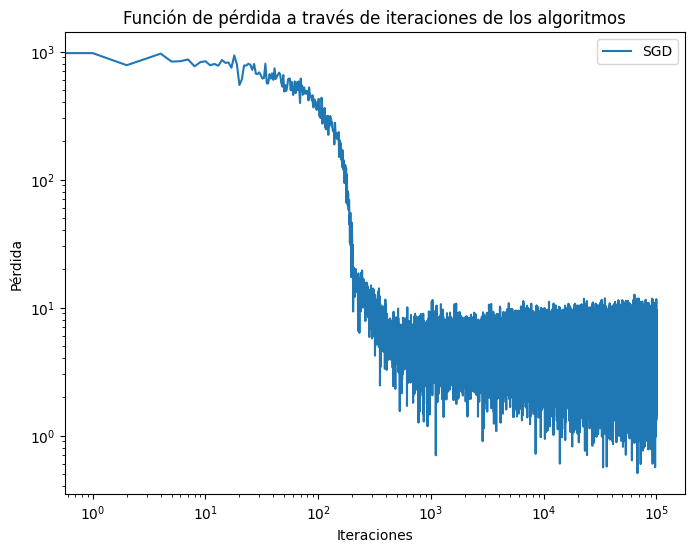

In [ ]:
# Gráfico de la función de pérdida
plt.figure(figsize=(8,6))
plt.plot(range(iters), loss_history_sgd, label="SGD")
plt.legend()
plt.xlabel("Iteraciones")
plt.ylabel("Pérdida")
plt.title("Función de pérdida a través de iteraciones de los algoritmos")
plt.xscale("log")
plt.yscale("log")
plt.show()

## **Añadimos momentum**

In [ ]:
# Añadimos momentum
# Tamaño de los batches
batch_size = 5

# Se comienza con parámetros aleatorios
x_mom = params

m = np.zeros(len(x_mom)) # Primer momento

# Parámetros
alpha, beta = 1e-3, 0.9

# Cantidad de iteraciones
iters = 100000

# Guardamos la pérdida a través de las iteraciones
loss_history_mom = np.zeros(iters)

# Learning rate
lr = 1e-3

time_mom = time()
# Iteraciones del algoritmo
for i in range(iters):
    g = grad_loss(x_mom, batch_size)             # Gradientes
    m = beta*m + (1 - beta)*g                # Actualización del primer momento
    x_mom = x_mom - lr*m                             # Actualización
    loss_history_mom[i] = loss(x_mom, batch_size)    # Guardamos la pérdida
time_mom = time() - time_mom

print(f"Tiempo de ejecución: {time_mom}")

Tiempo de ejecución: 94.97532844543457


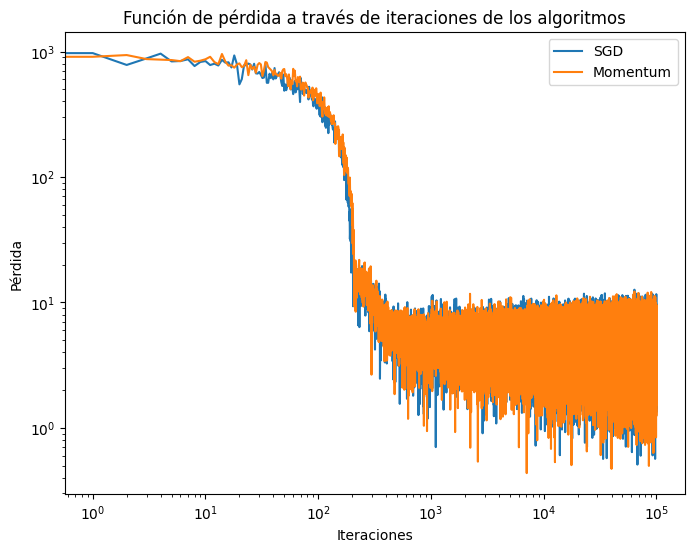

In [ ]:
# Gráfico de la función de pérdida
plt.figure(figsize=(8,6))
plt.plot(range(iters), loss_history_sgd, label="SGD")
plt.plot(range(iters), loss_history_mom, label="Momentum")
plt.legend()
plt.xlabel("Iteraciones")
plt.ylabel("Pérdida")
plt.title("Función de pérdida a través de iteraciones de los algoritmos")
plt.xscale("log")
plt.yscale("log")
plt.show()

## **Llegamos a Adam**

In [ ]:
# Algoritmo Adam
# Tamaño de los batches
batch_size = 5

# Se comienza con parámetros aleatorios
x_adam = params

m = np.zeros(len(x_adam)) # Primer momento
v = np.zeros(len(x_adam)) # Segundo momento

# Parámetros del optimizador Adam
alpha, b1, b2, eps = 1e-3, 0.9, 0.999, 1e-8

# Cantidad de iteraciones
iters = 100000

# Guardamos la pérdida a través de las iteraciones
loss_history_adam = np.zeros(iters)

time_adam = time()
# Iteraciones del algoritmo
for i in range(iters):
    g = grad_loss(x_adam, batch_size)             # Gradientes
    m = (1 - b1) * g      + b1 * m           # Actualización del primer momento
    v = (1 - b2) * (g**2) + b2 * v           # Actualización del segundo momento
    mhat = m / (1 - b1**(i + 1))             # Corrección del primer momento sesgado
    vhat = v / (1 - b2**(i + 1))             # Corrección del segundo momento sesgado
    x_adam = x_adam - alpha*mhat/(np.sqrt(vhat) + eps) # Actualización de parámetros con corrección y learning rate
    loss_history_adam[i] = loss(x_adam, batch_size)    # Guardamos la pérdida

time_adam = time() - time_adam

print(f"Tiempo de ejecución: {time_adam}")

Tiempo de ejecución: 102.18549609184265


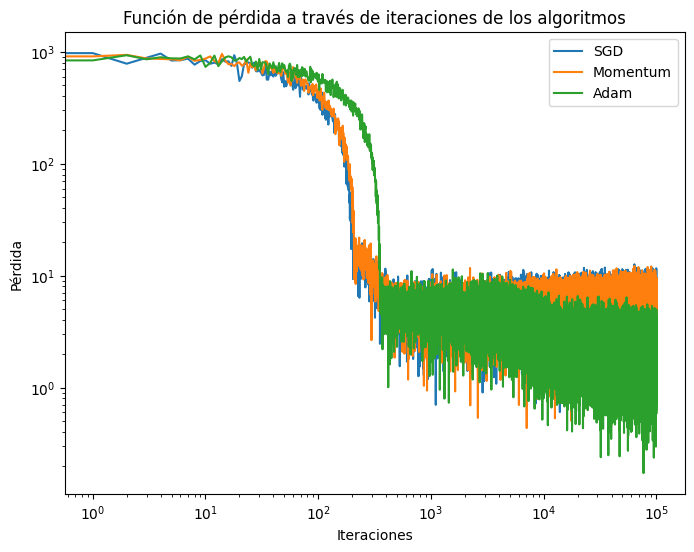

In [ ]:
# Gráfico de la función de pérdida
plt.figure(figsize=(8,6))
plt.plot(range(iters), loss_history_sgd, label="SGD")
plt.plot(range(iters), loss_history_mom, label="Momentum")
plt.plot(range(iters), loss_history_adam, label="Adam")
plt.legend()
plt.xlabel("Iteraciones")
plt.ylabel("Pérdida")
plt.title("Función de pérdida a través de iteraciones de los algoritmos")
plt.xscale("log")
plt.yscale("log")
plt.show()

## **Comparación de los resultados**

In [ ]:
# Comparación de las red

# Genera datos para testear
x_test = np.linspace(0, 1, 100).reshape((1,-1))
y_test = f_true(x_test)

# Define funciones lambda para calcular las predicciones de cada modelo
net_sgd = lambda p: net(p, x_test)
net_mom = lambda p: net(p, x_test)
net_adam = lambda p: net(p, x_test)

# Calcula las predicciones de cada modelo utilizando los parámetros optimizados
y_sgd = net_sgd(x_sgd)
y_mom = net_mom(x_mom)
y_adam = net_adam(x_adam)

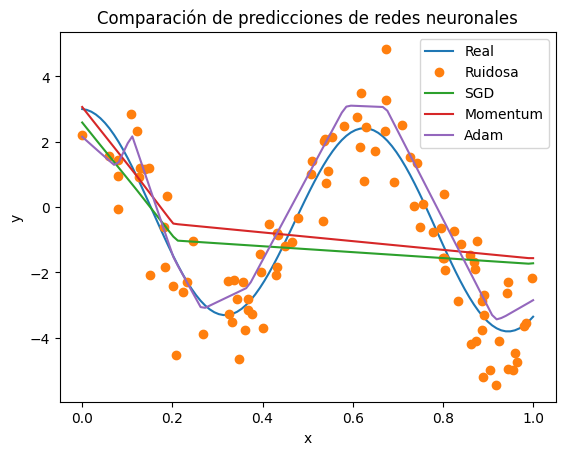

In [ ]:
# Grafica las predicciones de cada modelo comparadas con los datos reales
plt.plot(x_test.flatten(), y_test.flatten(), label="Real")
plt.plot(x_train.flatten(), y_train.flatten(), "o", label="Ruidosa")
plt.plot(x_test.flatten(), y_sgd.flatten(), label="SGD")
plt.plot(x_test.flatten(), y_mom.flatten(), label="Momentum")
plt.plot(x_test.flatten(), y_adam.flatten(), label="Adam")
# Añade una etiqueta al eje x
plt.xlabel("x")
# Añade una etiqueta al eje y
plt.ylabel("y")
# Añade un título al gráfico
plt.title("Comparación de predicciones de redes neuronales")
# Muestra la leyenda del gráfico
plt.legend()
plt.show()

In [ ]:
# Calcula el error (norma L2 de la diferencia) entre los valores reales y las predicciones de cada modelo
error_sgd = np.linalg.norm(y_test - y_sgd)
error_mom = np.linalg.norm(y_test - y_mom)
error_adam = np.linalg.norm(y_test - y_adam)

# Imprime los errores calculados para cada modelo
print(f"Error de SGD: {error_sgd}")
print(f"Error de Momentum: {error_mom}")
print(f"Error de Adam: {error_adam}")

print()

# Imprime los tiempos de ejecución
print(f"Tiempo de ejecución SGD: {time_sgd}")
print(f"Tiempo de ejecución Momentum: {time_mom}")
print(f"Tiempo de ejecución Adam: {time_adam}")

Error de SGD: 19.538493205567228
Error de Momentum: 19.387756168933908
Error de Adam: 6.574601977148392

Tiempo de ejecución SGD: 89.88808727264404
Tiempo de ejecución Momentum: 94.97532844543457
Tiempo de ejecución Adam: 102.18549609184265
